In [1]:
import cv2
import imghdr
import torch
import torch.nn as nn

import os 
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision.datasets as datasets

In [2]:
Train_set = 'train'
Test_set = 'test'
print("Training Classes:", os.listdir(Train_set))
print("Test Classes:", os.listdir(Test_set))


Training Classes: ['cats', 'dogs']
Test Classes: ['cats', 'dogs']


In [3]:
# Count total number of images in test set
total_test_images = sum(len(files) for _, _, files in os.walk(Test_set))
print("Total number of Test images:", total_test_images)


Total number of Test images: 140


In [15]:
# Count total number of images in training set
total_train_images = sum(len(files) for _, _, files in os.walk(Train_set))
print("Total number of Train images:", total_train_images)


Total number of Train images: 557


In [5]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train = datasets.ImageFolder(Train_set, transform=transform)
test =  datasets.ImageFolder(Test_set, transform=transform)

In [7]:

batch_size = 16
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [9]:
# Define the device (GPU or CPU)
device = ('cuda')


In [10]:

import torchvision.models as models

# Define the model
class ImageClassificationModule(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.1):
        super(ImageClassificationModule, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Dropout(p=dropout_rate)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x


In [11]:
# Initialize the model and move it to the device
from torchsummary import summary
model = ImageClassificationModule().to(device)

summary(model, input_size=(3, 224, 224))


C:\Users\dell 5590 i7\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell 5590 i7\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [12]:
import torch.optim as optim


In [13]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [17]:
# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    # Print training statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {train_loss / len(train_loader):.4f}, '
          f'Training Accuracy: {100 * train_correct / total_train_images:.2f}%')

Epoch [1/30], Training Loss: 0.0710, Training Accuracy: 96.95%
Epoch [2/30], Training Loss: 0.0936, Training Accuracy: 96.59%
Epoch [3/30], Training Loss: 0.1014, Training Accuracy: 95.87%
Epoch [4/30], Training Loss: 0.0730, Training Accuracy: 96.41%
Epoch [5/30], Training Loss: 0.0967, Training Accuracy: 96.77%
Epoch [6/30], Training Loss: 0.0749, Training Accuracy: 96.23%
Epoch [7/30], Training Loss: 0.1127, Training Accuracy: 95.33%
Epoch [8/30], Training Loss: 0.1293, Training Accuracy: 95.15%
Epoch [9/30], Training Loss: 0.1236, Training Accuracy: 95.15%
Epoch [10/30], Training Loss: 0.0782, Training Accuracy: 96.41%
Epoch [11/30], Training Loss: 0.0712, Training Accuracy: 97.31%
Epoch [12/30], Training Loss: 0.1056, Training Accuracy: 94.97%
Epoch [13/30], Training Loss: 0.0703, Training Accuracy: 96.77%
Epoch [14/30], Training Loss: 0.0903, Training Accuracy: 96.23%
Epoch [15/30], Training Loss: 0.1131, Training Accuracy: 95.69%
Epoch [16/30], Training Loss: 0.1144, Training Ac

In [18]:
# Test the model
model.eval()  
test_loss = 0.0
test_correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

# Calculate average test loss
average_test_loss = test_loss / len(test_loader)

# Print test statistics
print(f'Test Loss: {average_test_loss:.4f}, '
      f'Test Accuracy: {100 * test_correct / total_test_images:.2f}%')


Test Loss: 0.2378, Test Accuracy: 92.14%


In [19]:
# save the model
torch.save(model.state_dict(), 'imageclassifiermodel.pth')

# Deploying the model

In [22]:

from PIL import Image

# Function to load and preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = Image.fromarray(image) 
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image)
    return image.unsqueeze(0)  

In [23]:

image_path = 'cat.jpeg'

# Preprocess the image
input_image = preprocess_image(image_path)
input_image = input_image.to(device)

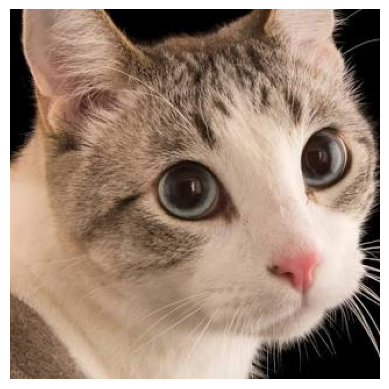

In [27]:

image = cv2.imread('cat.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off') 
plt.show()

In [25]:

# Set the model to evaluation mode
model.eval()
# Make predictions
with torch.no_grad():
    output = model(input_image)

# Get the predicted class index
_, predicted_class = torch.max(output, 1)

# Map class index to class labels
class_labels = {0: 'cat', 1: 'dog'}

# Print the predicted class label
predicted_label = class_labels[predicted_class.item()]
print(f'Predicted Class: {predicted_label}')

# Get predicted probabilities in percentage
probabilities = torch.sigmoid(output)
cat_probability = probabilities[0, 0].item() * 100
dog_probability = probabilities[0, 1].item() * 100

# Print predicted probabilities
print(f'Probability for Cat: {cat_probability:.2f}%')
print(f'Probability for Dog: {dog_probability:.2f}%')

Predicted Class: cat
Probability for Cat: 99.01%
Probability for Dog: 0.68%


In [26]:
image_path = 'dog.jpeg'

# Preprocess the image
input_image = preprocess_image(image_path)
input_image = input_image.to(device)

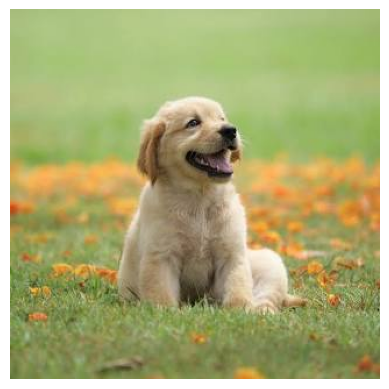

In [28]:
image = cv2.imread('dog.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off') 
plt.show()

In [29]:

# Set the model to evaluation mode
model.eval()
# Make predictions
with torch.no_grad():
    output = model(input_image)

# Get the predicted class index
_, predicted_class = torch.max(output, 1)

# Map class index to class labels
class_labels = {0: 'cat', 1: 'dog'}

# Print the predicted class label
predicted_label = class_labels[predicted_class.item()]
print(f'Predicted Class: {predicted_label}')

# Get predicted probabilities in percentage
probabilities = torch.sigmoid(output)
cat_probability = probabilities[0, 0].item() * 100
dog_probability = probabilities[0, 1].item() * 100

# Print predicted probabilities
print(f'Probability for Cat: {cat_probability:.2f}%')
print(f'Probability for Dog: {dog_probability:.2f}%')

Predicted Class: dog
Probability for Cat: 0.05%
Probability for Dog: 99.95%


In [33]:
image_path = 'lion.jpeg'

# Preprocess the image
input_image = preprocess_image(image_path)
input_image = input_image.to(device)

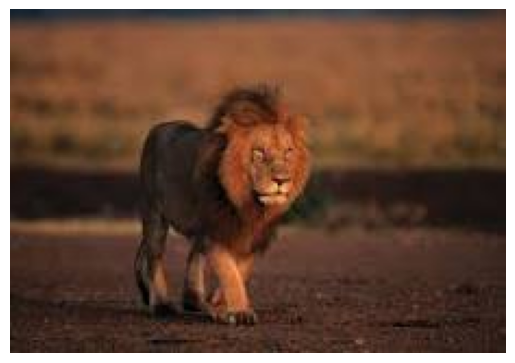

In [34]:
image = cv2.imread('lion.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off') 
plt.show()

In [35]:

# Set the model to evaluation mode
model.eval()
# Make predictions
with torch.no_grad():
    output = model(input_image)

# Get the predicted class index
_, predicted_class = torch.max(output, 1)

# Map class index to class labels
class_labels = {0: 'cat', 1: 'dog'}

# Print the predicted class label
predicted_label = class_labels[predicted_class.item()]
print(f'Predicted Class: {predicted_label}')

# Get predicted probabilities in percentage
probabilities = torch.sigmoid(output)
cat_probability = probabilities[0, 0].item() * 100
dog_probability = probabilities[0, 1].item() * 100

# Print predicted probabilities
print(f'Probability for Cat: {cat_probability:.2f}%')
print(f'Probability for Dog: {dog_probability:.2f}%')

Predicted Class: dog
Probability for Cat: 42.00%
Probability for Dog: 50.74%
